#üìå Extrac√£o

In [3]:
import pandas as pd
import requests

# URL da API (ajuste conforme necess√°rio)
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/main/TelecomX_Data.json"

# Carregar os dados da API
response = requests.get(url)

# Verificar se a requisi√ß√£o foi bem-sucedida
if response.status_code == 200:
    # Converter os dados JSON para um dicion√°rio Python
    data = response.json()

    # Criar DataFrame do Pandas
    df = pd.DataFrame(data)

    # Mostrar as primeiras linhas para verifica√ß√£o
    print("Dados carregados com sucesso!")
    print("\nPrimeiras linhas do DataFrame:")
    print(df.head())

    # Se quiser ver informa√ß√µes sobre as colunas e tipos de dados
    print("\nInforma√ß√µes do DataFrame:")
    print(df.info())
else:
    print(f"Erro ao acessar a API. C√≥digo de status: {response.status_code}")

Dados carregados com sucesso!

Primeiras linhas do DataFrame:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineSecurity': '...   


#üîß Transforma√ß√£o

In [9]:
import pandas as pd
import ast

# Fun√ß√£o para desaninhar colunas-dicion√°rio
def expand_dict_columns(df, column):
    return pd.json_normalize(df[column].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x))

# Desaninhando cada coluna complexa
customer_expanded = expand_dict_columns(df, 'customer')
phone_expanded = expand_dict_columns(df, 'phone')
internet_expanded = expand_dict_columns(df, 'internet')
account_expanded = expand_dict_columns(df, 'account')

# Juntando tudo no DataFrame original
df_clean = pd.concat([
    df[['customerID', 'Churn']],
    customer_expanded,
    phone_expanded,
    internet_expanded,
    account_expanded
], axis=1)

# Verificando o resultado
print("Dataset ap√≥s desaninhamento:")
print(df_clean.head(2))
print("\nNovas colunas dispon√≠veis:")
print(df_clean.columns.tolist())

# Agora podemos processar normalmente
# 1. Converter Churn para bin√°rio
df_clean['Churn'] = df_clean['Churn'].map({'Yes': 1, 'No': 0})

# 2. Criar coluna Contas_Diarias (assumindo que MonthlyCharges est√° em account)
if 'MonthlyCharges' in df_clean.columns:
    df_clean['Contas_Diarias'] = df_clean['MonthlyCharges'] / 30
    df_clean['Contas_Diarias'] = df_clean['Contas_Diarias'].round(2)
else:
    print("\nAviso: Coluna 'MonthlyCharges' n√£o encontrada - verifique os nomes das colunas")

# 3. Converter outras colunas categ√≥ricas
binary_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']
for col in binary_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map({'Yes': 1, 'No': 0})

# 4. One-hot encoding para categorias m√∫ltiplas
cat_cols = ['InternetService', 'Contract', 'PaymentMethod']
df_clean = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)

# Resultado final
print("\nDataset processado:")
print(df_clean.info())



Dataset ap√≥s desaninhamento:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   

  PhoneService MultipleLines InternetService  ... OnlineBackup  \
0          Yes            No             DSL  ...          Yes   
1          Yes           Yes             DSL  ...           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No         Yes         Yes              No        One year   
1               No          No          No             Yes  Month-to-month   

  PaperlessBilling PaymentMethod Charges.Monthly  Charges.Total  
0              Yes  Mailed check            65.6          593.3  
1               No  Mailed check            59.9          542.4  

[2 rows x 21 columns]

Novas colunas dispon√≠veis:
['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dep

#üìä Carga e an√°lise

An√°lise descritiva das colunas num√©ricas existentes:
                       mean   50%        std    min     max    IQR        CV
Churn              0.265370   0.0   0.441561   0.00    1.00   1.00  1.663947
SeniorCitizen      0.162653   0.0   0.369074   0.00    1.00   0.00  2.269089
Partner            0.484106   0.0   0.499782   0.00    1.00   1.00  1.032380
Dependents         0.300124   0.0   0.458343   0.00    1.00   1.00  1.527180
tenure            32.346498  29.0  24.571773   0.00   72.00  46.00  0.759642
PhoneService       0.902711   1.0   0.296371   0.00    1.00   0.00  0.328313
PaperlessBilling   0.593230   1.0   0.491265   0.00    1.00   1.00  0.828120
Charges.Monthly   64.720098  70.3  30.129572  18.25  118.75  54.45  0.465537

Principais insights:

Taxa de evas√£o (Churn): 26.54%

Tempo como cliente (tenure):
- M√©dia: 32.3 meses
- 25% dos clientes t√™m at√© 9.0 meses
- 50% dos clientes t√™m at√© 29.0 meses

Gastos mensais (Charges.Monthly):
- M√©dia: $64.72
- Varia√ß√£o: $

/tmp/ipython-input-466653849.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_by_tenure = df_clean.groupby('tenure_group')['Churn'].mean()


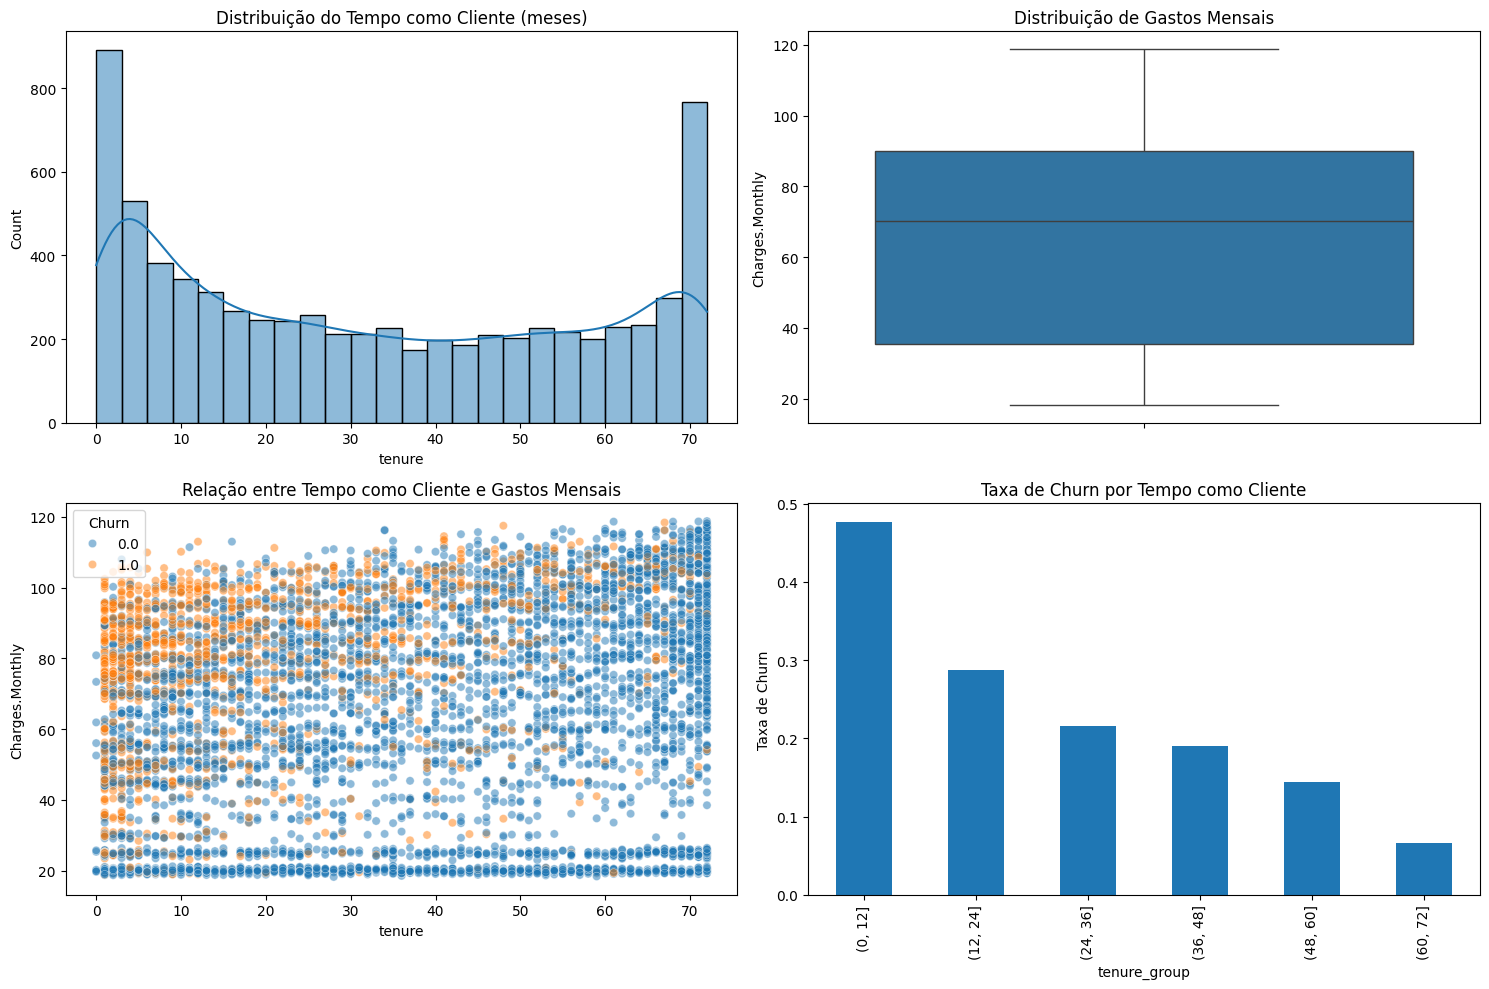


Matriz de correla√ß√£o:


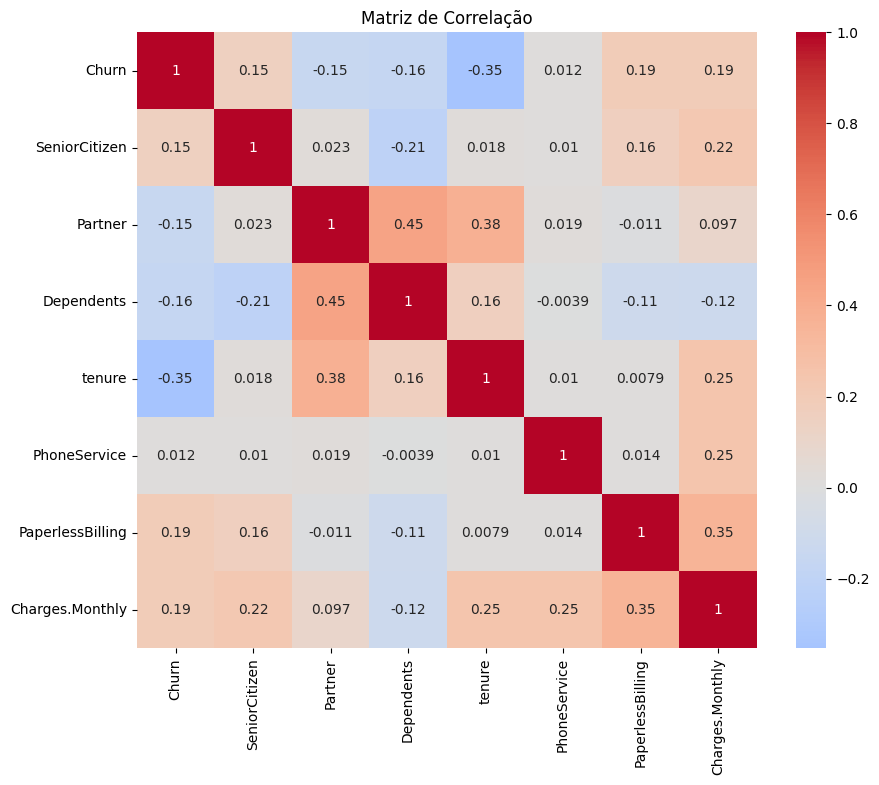


Pr√≥ximos passos sugeridos:
1. Criar a coluna 'Contas_Diarias' a partir de 'Charges.Monthly'
2. Analisar diferen√ßas entre grupos demogr√°ficos (g√™nero, SeniorCitizen)
3. Investigar a rela√ß√£o entre tipo de contrato e churn
4. Verificar padr√µes nos servi√ßos adicionais (OnlineSecurity, TechSupport)


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. FOCAR NAS COLUNAS DISPON√çVEIS
print("An√°lise descritiva das colunas num√©ricas existentes:")

# Vari√°veis num√©ricas confirmadas
numeric_cols = ['Churn', 'SeniorCitizen', 'Partner', 'Dependents',
                'tenure', 'PhoneService', 'PaperlessBilling', 'Charges.Monthly']

# 2. ESTAT√çSTICAS DESCRITIVAS COMPLETAS
desc_stats = df_clean[numeric_cols].describe(percentiles=[.25, .5, .75]).transpose()
desc_stats['IQR'] = desc_stats['75%'] - desc_stats['25%']
desc_stats['CV'] = desc_stats['std'] / desc_stats['mean']

print(desc_stats[['mean', '50%', 'std', 'min', 'max', 'IQR', 'CV']])

# 3. AN√ÅLISE DAS VARI√ÅVEIS-CHAVE EXISTENTES
print("\nPrincipais insights:")

# 3.1 An√°lise de Churn
churn_rate = df_clean['Churn'].mean()
print(f"\nTaxa de evas√£o (Churn): {churn_rate:.2%}")

# 3.2 Tempo como cliente (tenure)
print("\nTempo como cliente (tenure):")
print(f"- M√©dia: {desc_stats.loc['tenure','mean']:.1f} meses")
print(f"- 25% dos clientes t√™m at√© {desc_stats.loc['tenure','25%']} meses")
print(f"- 50% dos clientes t√™m at√© {desc_stats.loc['tenure','50%']} meses")

# 3.3 Gastos mensais (Charges.Monthly)
print("\nGastos mensais (Charges.Monthly):")
print(f"- M√©dia: ${desc_stats.loc['Charges.Monthly','mean']:.2f}")
print(f"- Varia√ß√£o: ${desc_stats.loc['Charges.Monthly','min']:.2f} a ${desc_stats.loc['Charges.Monthly','max']:.2f}")

# 4. VISUALIZA√á√ïES
plt.figure(figsize=(15, 10))

# 4.1 Distribui√ß√£o do tempo como cliente
plt.subplot(2, 2, 1)
sns.histplot(data=df_clean, x='tenure', bins=24, kde=True)
plt.title('Distribui√ß√£o do Tempo como Cliente (meses)')

# 4.2 Boxplot de gastos mensais
plt.subplot(2, 2, 2)
sns.boxplot(data=df_clean, y='Charges.Monthly')
plt.title('Distribui√ß√£o de Gastos Mensais')

# 4.3 Rela√ß√£o entre tenure e Charges.Monthly
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_clean, x='tenure', y='Charges.Monthly', hue='Churn', alpha=0.5)
plt.title('Rela√ß√£o entre Tempo como Cliente e Gastos Mensais')

# 4.4 Taxa de churn por tempo como cliente
plt.subplot(2, 2, 4)
df_clean['tenure_group'] = pd.cut(df_clean['tenure'], bins=[0, 12, 24, 36, 48, 60, 72])
churn_by_tenure = df_clean.groupby('tenure_group')['Churn'].mean()
churn_by_tenure.plot(kind='bar')
plt.title('Taxa de Churn por Tempo como Cliente')
plt.ylabel('Taxa de Churn')

plt.tight_layout()
plt.show()

# 5. AN√ÅLISE DE CORRELA√á√ïES
print("\nMatriz de correla√ß√£o:")
corr_matrix = df_clean[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correla√ß√£o')
plt.show()

# 6. SUGEST√ïES PARA PR√ìXIMOS PASSOS
print("\nPr√≥ximos passos sugeridos:")
print("1. Criar a coluna 'Contas_Diarias' a partir de 'Charges.Monthly'")
print("2. Analisar diferen√ßas entre grupos demogr√°ficos (g√™nero, SeniorCitizen)")
print("3. Investigar a rela√ß√£o entre tipo de contrato e churn")
print("4. Verificar padr√µes nos servi√ßos adicionais (OnlineSecurity, TechSupport)")

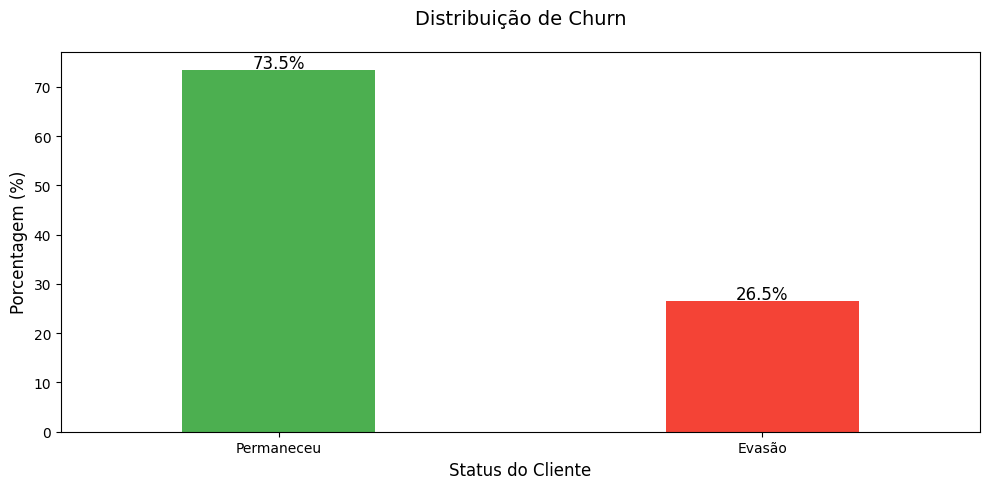

<Figure size 1000x600 with 0 Axes>

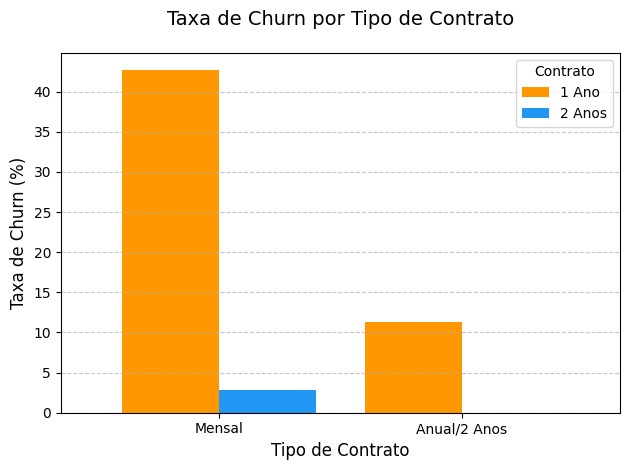

<Figure size 1000x600 with 0 Axes>

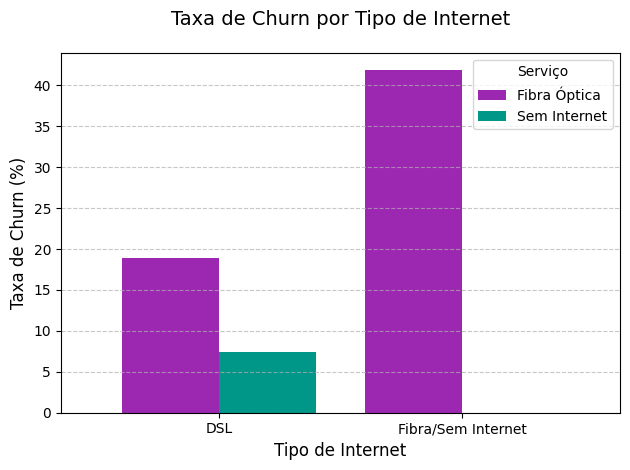

/tmp/ipython-input-3422038441.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df_clean.groupby('tenure_group')['Churn'].mean() * 100


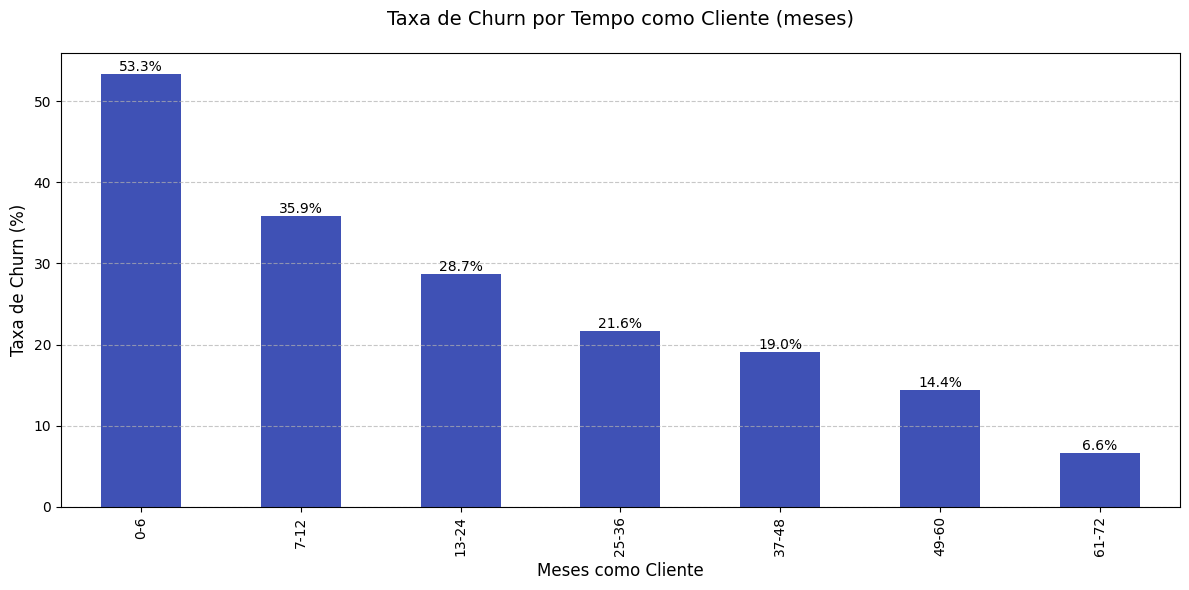

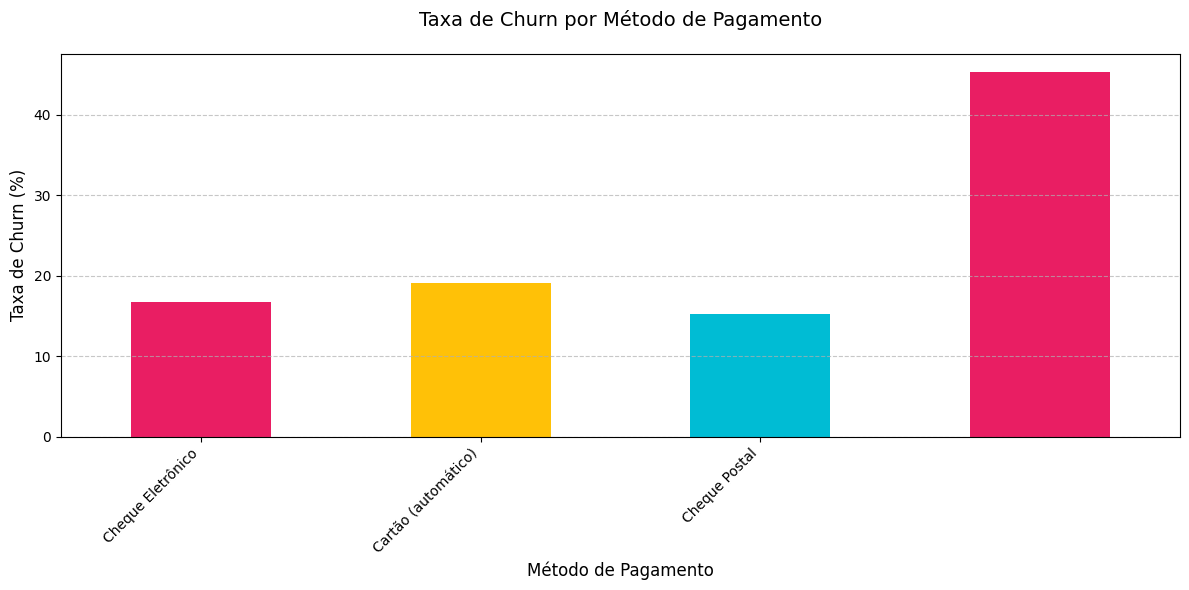

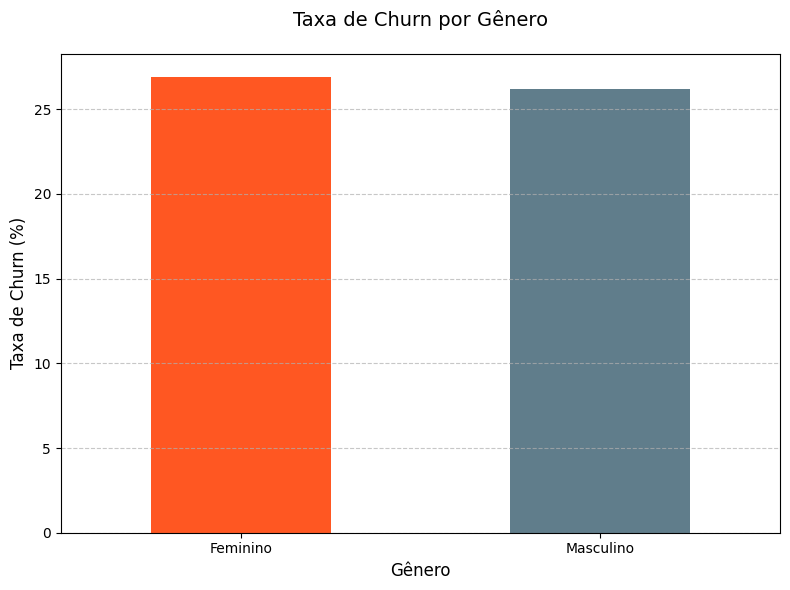

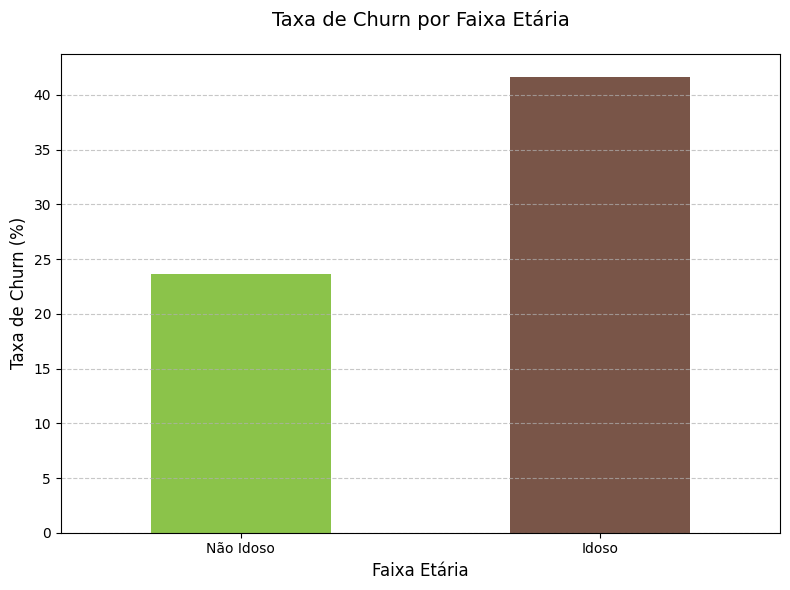

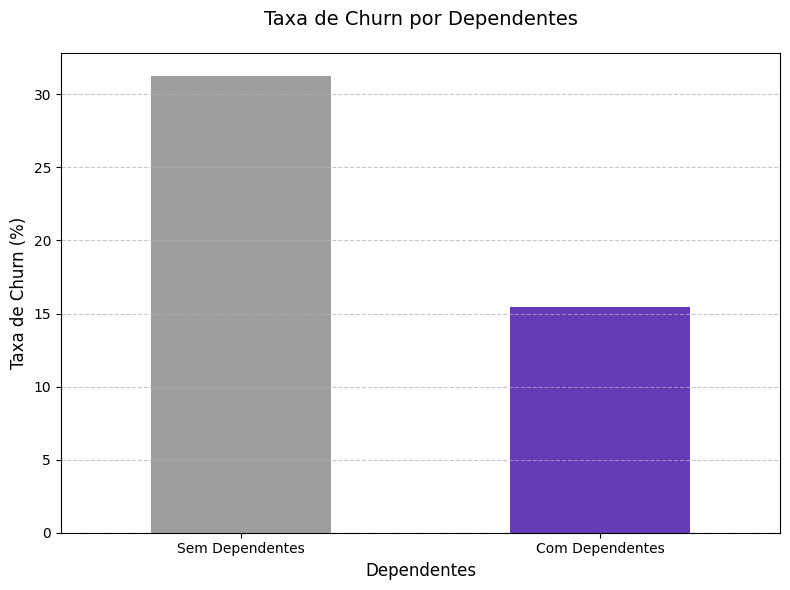

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Distribui√ß√£o Geral de Churn
plt.figure(figsize=(10, 5))
churn_dist = df_clean['Churn'].value_counts(normalize=True) * 100
ax = churn_dist.plot(kind='bar', color=['#4CAF50', '#F44336'], width=0.4)
plt.title('Distribui√ß√£o de Churn', pad=20, fontsize=14)
plt.ylabel('Porcentagem (%)', fontsize=12)
plt.xlabel('Status do Cliente', fontsize=12)
plt.xticks([0, 1], ['Permaneceu', 'Evas√£o'], rotation=0)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=12)
plt.tight_layout()
plt.show()

# 2. Gr√°ficos por Categorias

# 2.1 Por Tipo de Contrato
plt.figure(figsize=(10, 6))
contract_data = df_clean.groupby(['Contract_One year', 'Contract_Two year'])['Churn'].mean() * 100
contract_data.unstack().plot(kind='bar', color=['#FF9800', '#2196F3'], width=0.8)
plt.title('Taxa de Churn por Tipo de Contrato', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('Tipo de Contrato', fontsize=12)
plt.xticks([0, 1], ['Mensal', 'Anual/2 Anos'], rotation=0)
plt.legend(['1 Ano', '2 Anos'], title='Contrato')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.2 Por Tipo de Internet
plt.figure(figsize=(10, 6))
internet_data = df_clean.groupby(['InternetService_Fiber optic', 'InternetService_No'])['Churn'].mean() * 100
internet_data.unstack().plot(kind='bar', color=['#9C27B0', '#009688'], width=0.8)
plt.title('Taxa de Churn por Tipo de Internet', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('Tipo de Internet', fontsize=12)
plt.xticks([0, 1], ['DSL', 'Fibra/Sem Internet'], rotation=0)
plt.legend(['Fibra √ìptica', 'Sem Internet'], title='Servi√ßo')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.3 Por Tempo como Cliente
plt.figure(figsize=(12, 6))
df_clean['tenure_group'] = pd.cut(df_clean['tenure'],
                                 bins=[0, 6, 12, 24, 36, 48, 60, 72],
                                 labels=['0-6', '7-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
tenure_churn = df_clean.groupby('tenure_group')['Churn'].mean() * 100
ax = tenure_churn.plot(kind='bar', color='#3F51B5')
plt.title('Taxa de Churn por Tempo como Cliente (meses)', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('Meses como Cliente', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2.4 Por M√©todo de Pagamento
plt.figure(figsize=(12, 6))
payment_data = df_clean.groupby(['PaymentMethod_Electronic check',
                               'PaymentMethod_Credit card (automatic)',
                               'PaymentMethod_Mailed check'])['Churn'].mean() * 100
payment_data.plot(kind='bar', color=['#E91E63', '#FFC107', '#00BCD4'])
plt.title('Taxa de Churn por M√©todo de Pagamento', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('M√©todo de Pagamento', fontsize=12)
plt.xticks([0, 1, 2],
           ['Cheque Eletr√¥nico', 'Cart√£o (autom√°tico)', 'Cheque Postal'],
           rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. An√°lise Demogr√°fica

# 3.1 Por G√™nero
plt.figure(figsize=(8, 6))
gender_data = df_clean.groupby('gender')['Churn'].mean() * 100
gender_data.plot(kind='bar', color=['#FF5722', '#607D8B'])
plt.title('Taxa de Churn por G√™nero', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('G√™nero', fontsize=12)
plt.xticks([0, 1], ['Feminino', 'Masculino'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.2 Por Idosos
plt.figure(figsize=(8, 6))
senior_data = df_clean.groupby('SeniorCitizen')['Churn'].mean() * 100
senior_data.plot(kind='bar', color=['#8BC34A', '#795548'])
plt.title('Taxa de Churn por Faixa Et√°ria', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('Faixa Et√°ria', fontsize=12)
plt.xticks([0, 1], ['N√£o Idoso', 'Idoso'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3.3 Por Dependentes
plt.figure(figsize=(8, 6))
dependent_data = df_clean.groupby('Dependents')['Churn'].mean() * 100
dependent_data.plot(kind='bar', color=['#9E9E9E', '#673AB7'])
plt.title('Taxa de Churn por Dependentes', pad=20, fontsize=14)
plt.ylabel('Taxa de Churn (%)', fontsize=12)
plt.xlabel('Dependentes', fontsize=12)
plt.xticks([0, 1], ['Sem Dependentes', 'Com Dependentes'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


AN√ÅLISE DEMOGR√ÅFICA


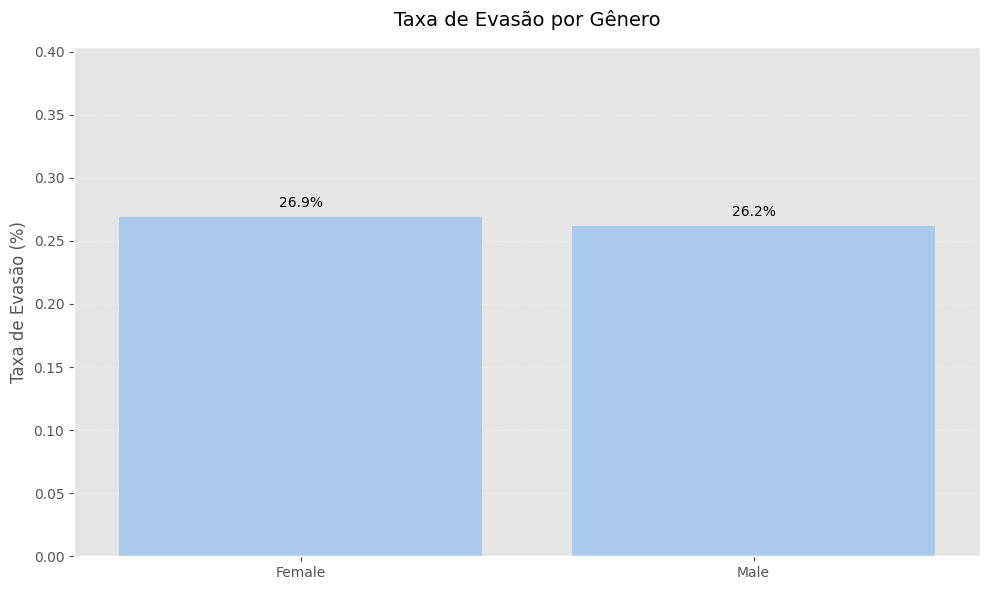

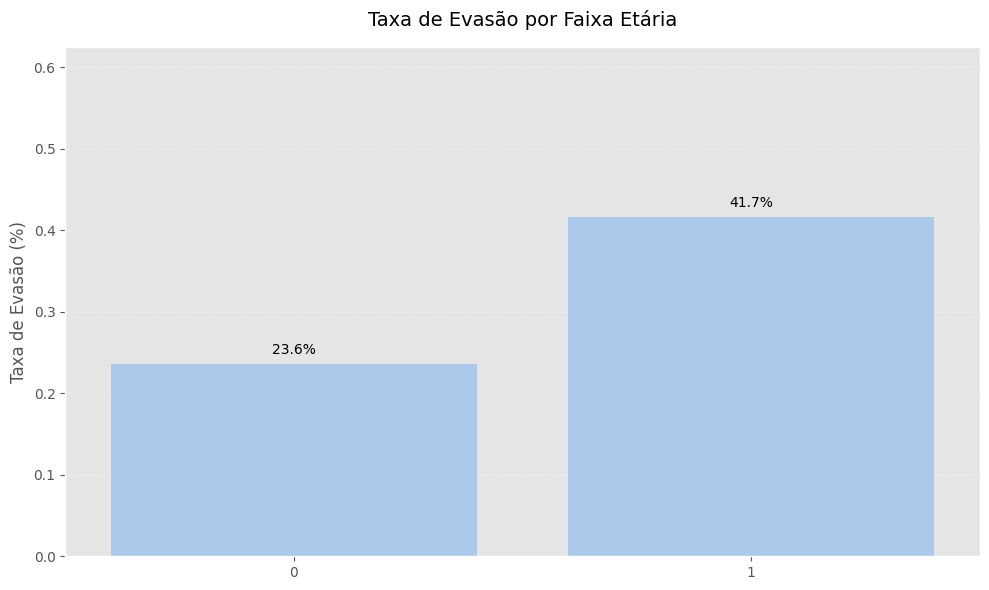

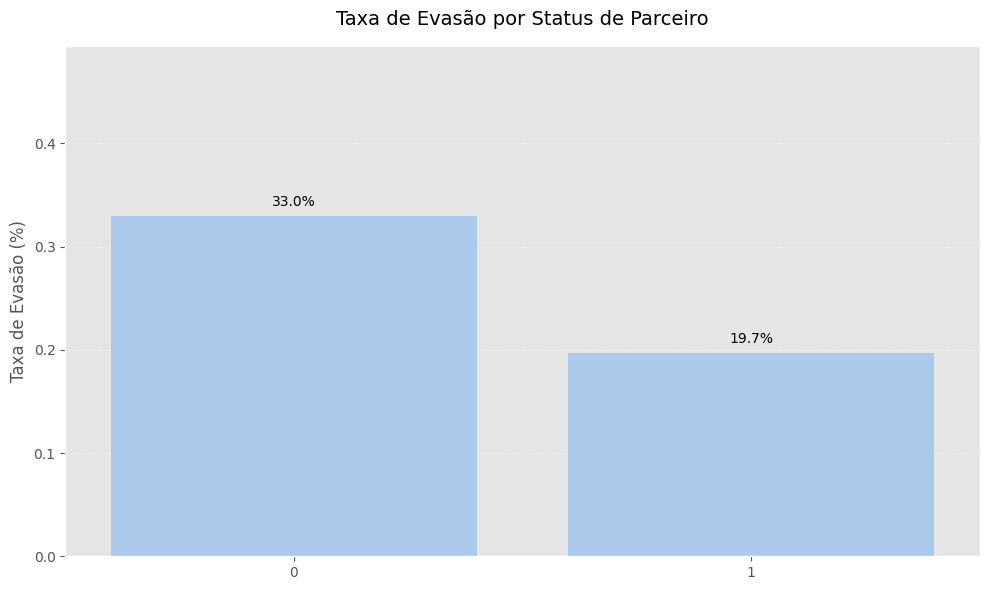

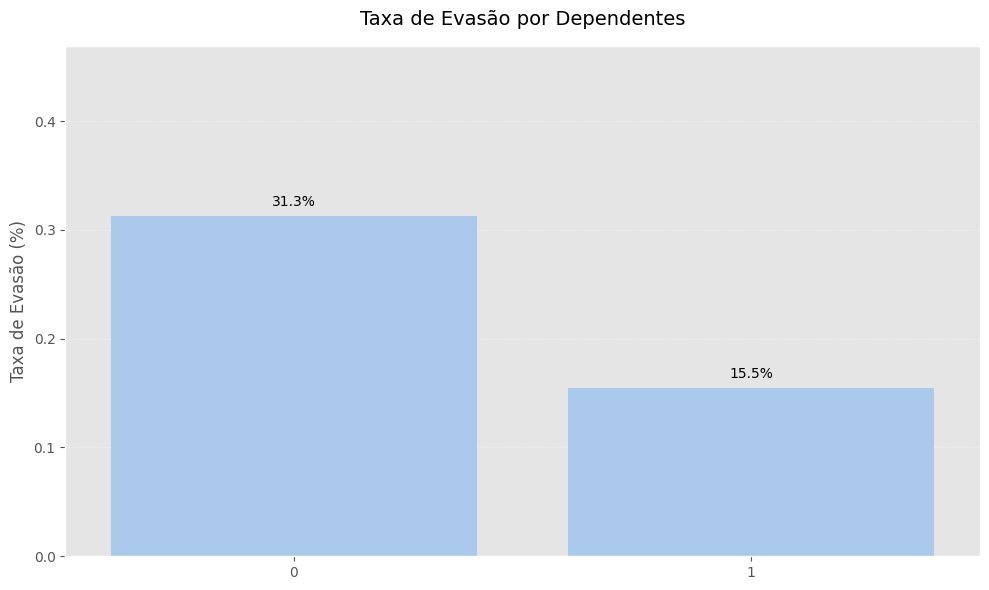


AN√ÅLISE POR SERVI√áOS


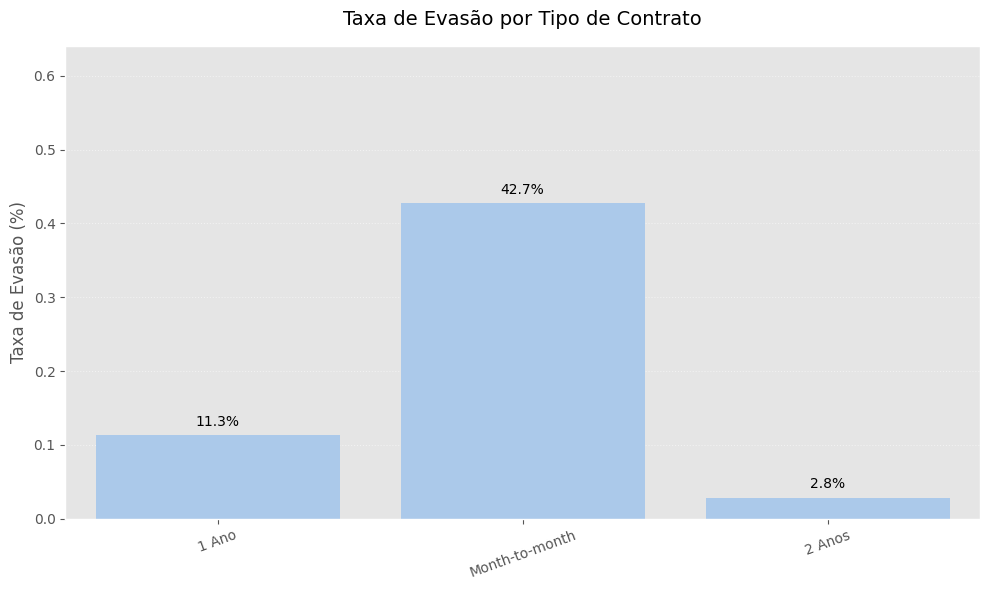

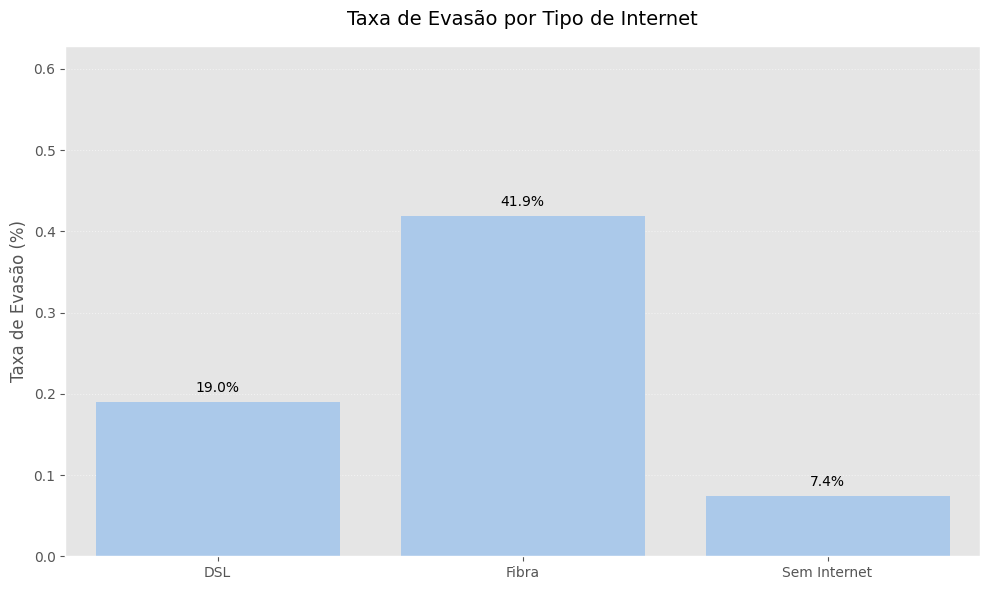

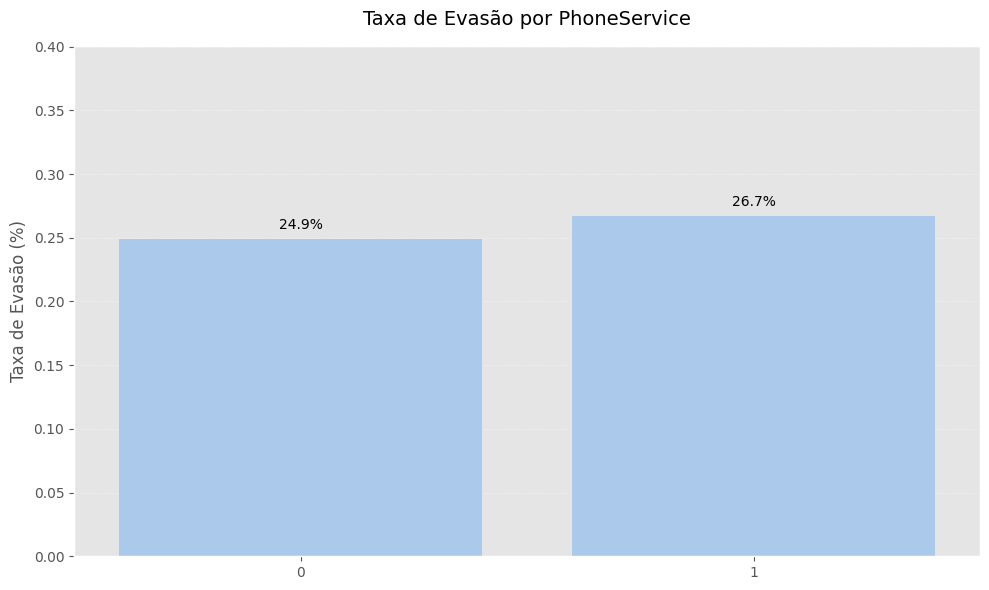

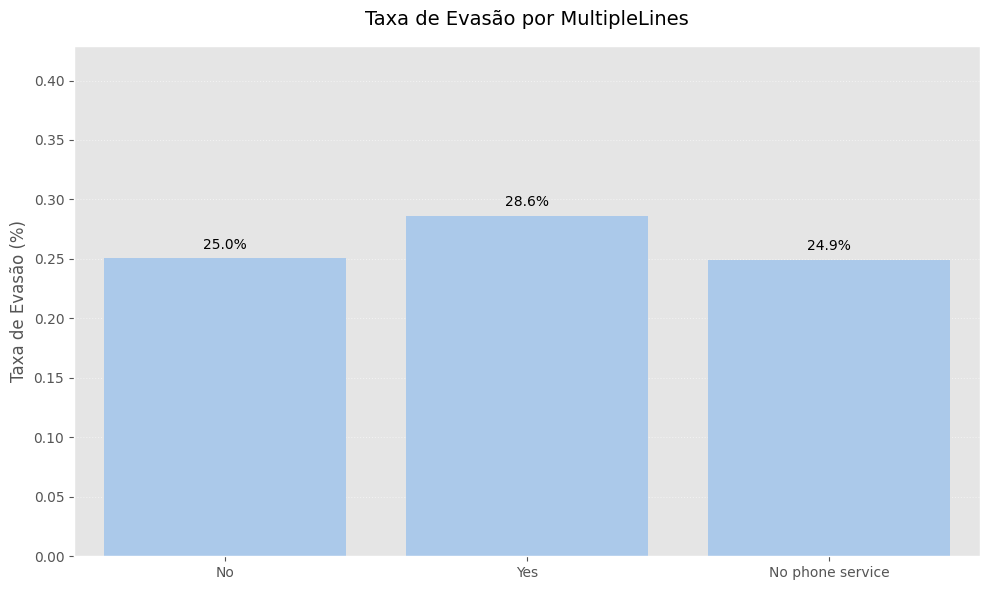

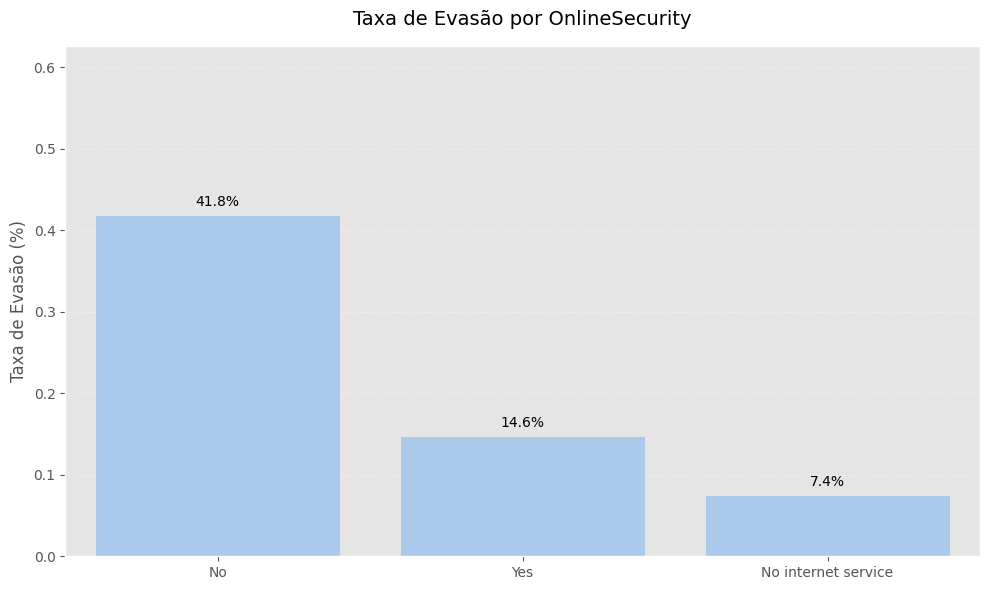

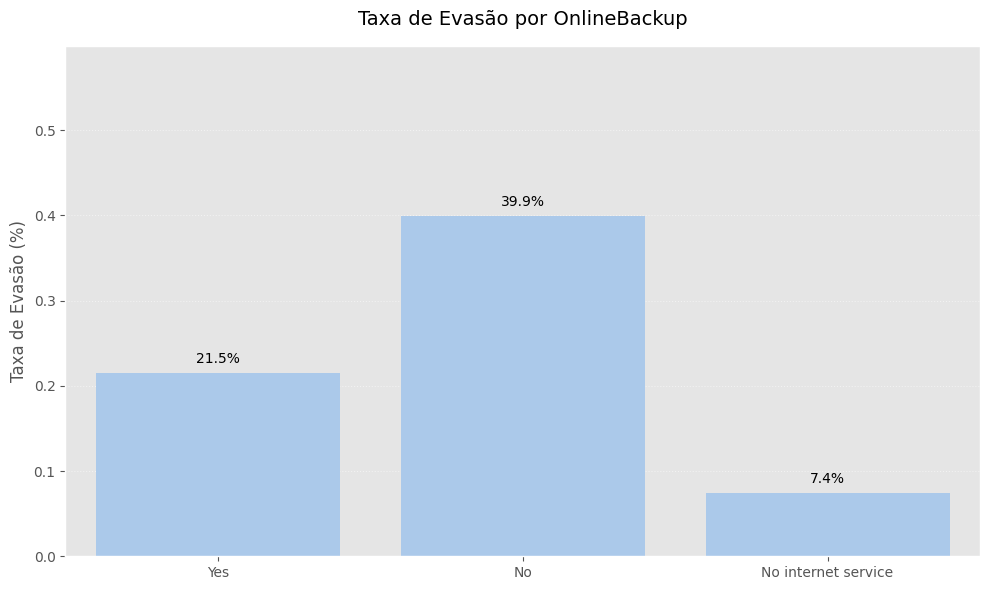

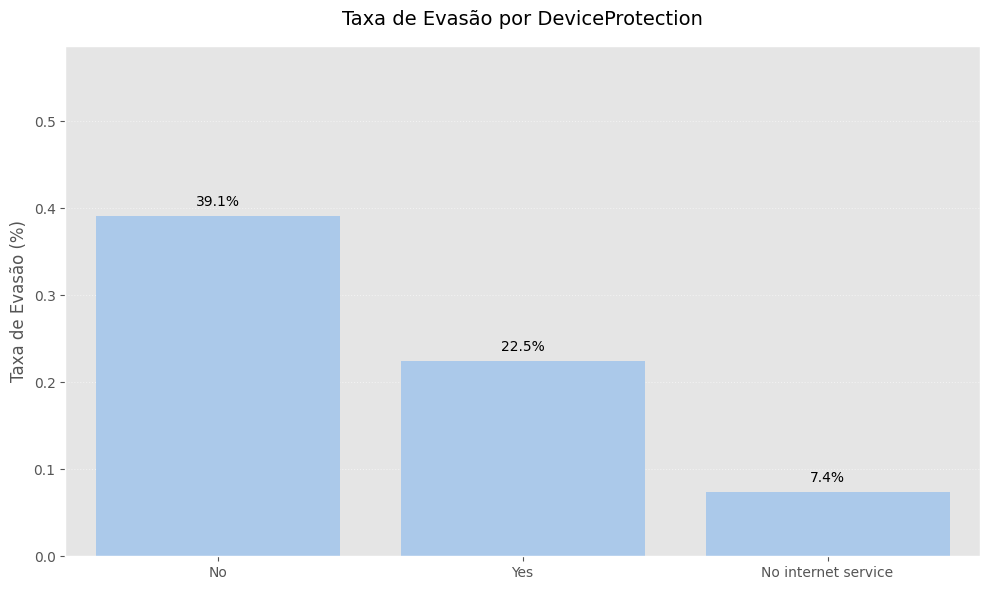

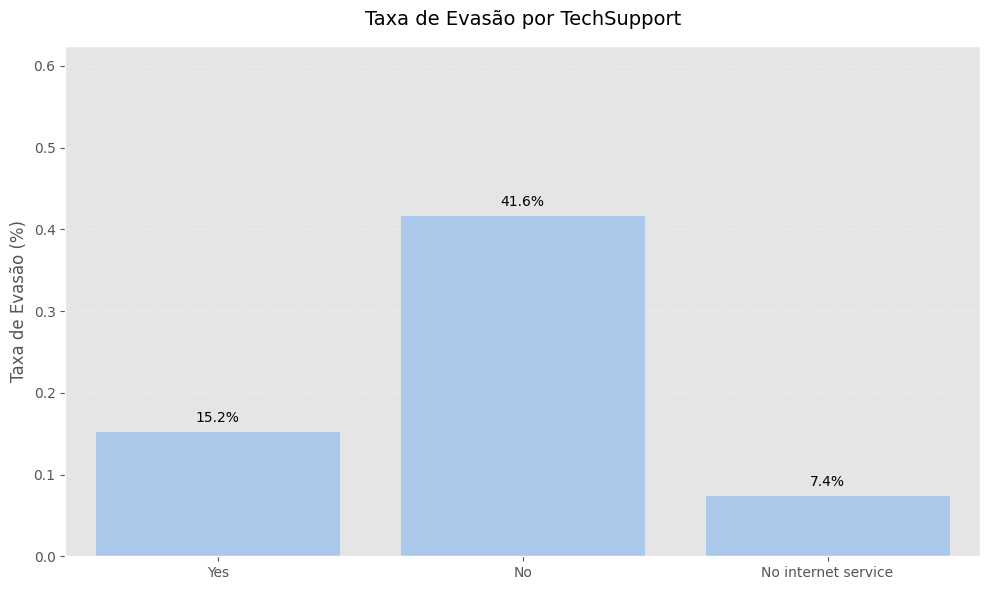

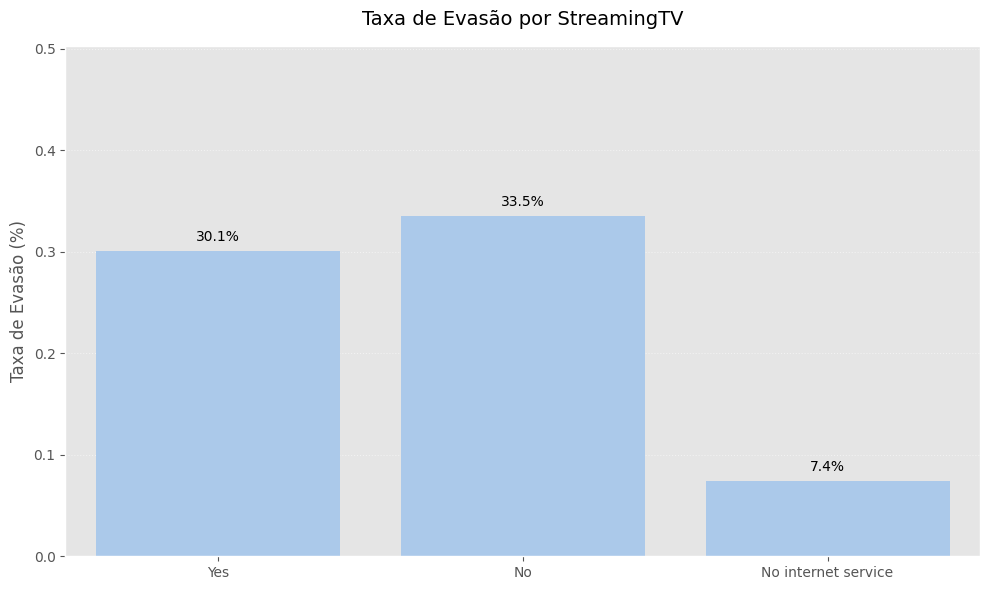

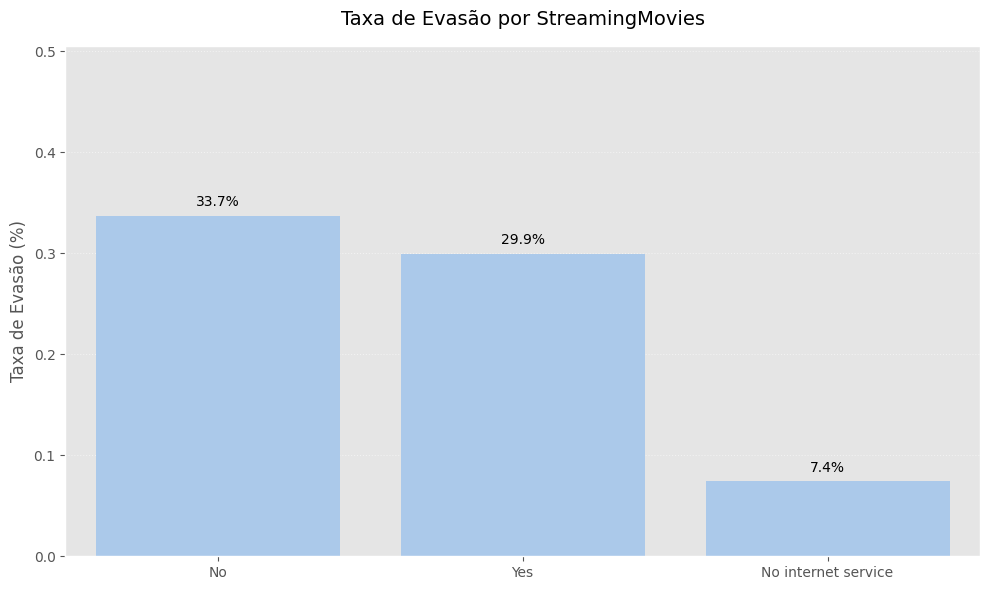


M√âTODOS DE PAGAMENTO


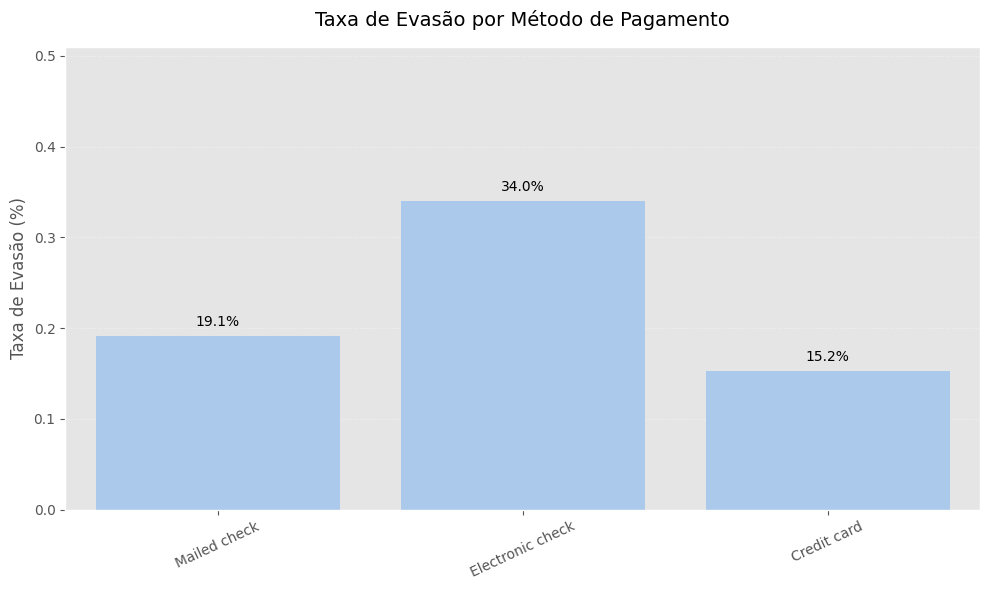


AN√ÅLISES CRUZADAS


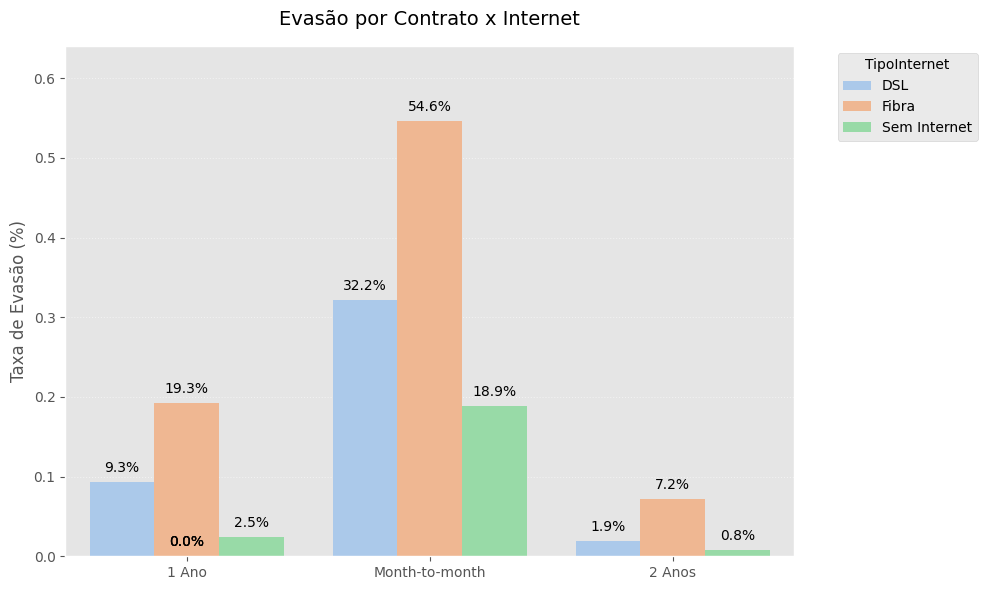

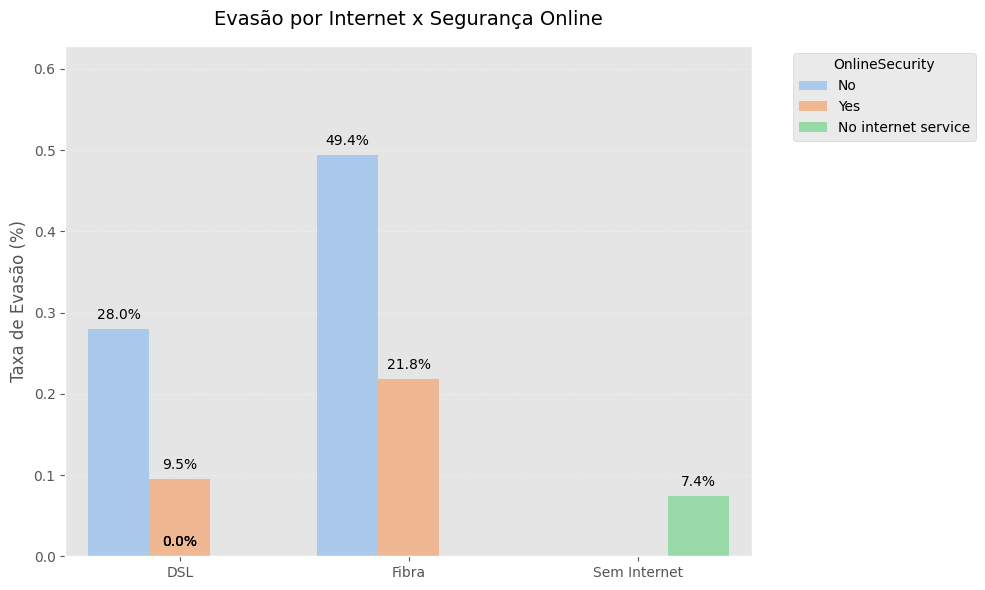


HEATMAP DE CORRELA√á√ÉO


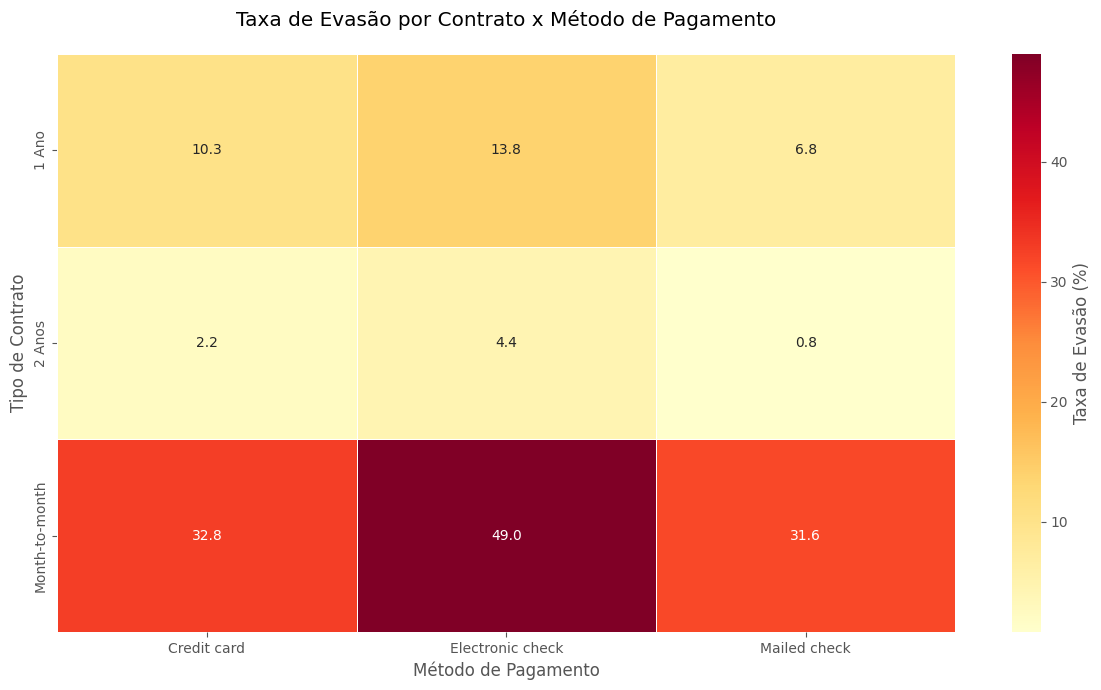

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Configura√ß√µes iniciais com estilo dispon√≠vel
plt.style.use('ggplot')  # Usando um estilo alternativo
sns.set_palette("pastel")
plt.rcParams['figure.max_open_warning'] = 50

# Verificar e preparar os dados
if not all(col in df_clean.columns for col in ['Contract_One year', 'Contract_Two year']):
    raise ValueError("Colunas de contrato n√£o encontradas no DataFrame")

# Criar colunas consolidadas
df_clean['TipoContrato'] = 'Month-to-month'
df_clean.loc[df_clean['Contract_One year'] == 1, 'TipoContrato'] = '1 Ano'
df_clean.loc[df_clean['Contract_Two year'] == 1, 'TipoContrato'] = '2 Anos'

df_clean['MetodoPagamento'] = 'Electronic check'
df_clean.loc[df_clean['PaymentMethod_Credit card (automatic)'] == 1, 'MetodoPagamento'] = 'Credit card'
df_clean.loc[df_clean['PaymentMethod_Mailed check'] == 1, 'MetodoPagamento'] = 'Mailed check'

df_clean['TipoInternet'] = 'DSL'
df_clean.loc[df_clean['InternetService_Fiber optic'] == 1, 'TipoInternet'] = 'Fibra'
df_clean.loc[df_clean['InternetService_No'] == 1, 'TipoInternet'] = 'Sem Internet'

# Fun√ß√£o otimizada para plotagem
def plot_churn(data, x, title, figsize=(10,6), rotation=0, hue=None, show=True):
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y='Churn', data=data, estimator=np.mean, hue=hue, errorbar=None)

    plt.title(title, fontsize=14, pad=15)
    plt.xlabel('')
    plt.ylabel('Taxa de Evas√£o (%)', fontsize=12)
    plt.xticks(rotation=rotation)

    # Ajuste din√¢mico do eixo Y
    max_rate = data.groupby(x)['Churn'].mean().max() * 1.5
    plt.ylim(0, min(max_rate, 1))

    # Adicionar valores nas barras
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height*100:.1f}%',
                   (p.get_x() + p.get_width()/2., height),
                   ha='center', va='center',
                   xytext=(0, 10),
                   textcoords='offset points',
                   fontsize=10)

    if hue:
        plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle=':', alpha=0.5)
    plt.tight_layout()
    if show:
        plt.show()
    return ax

# 1. An√°lise Demogr√°fica
print("\nAN√ÅLISE DEMOGR√ÅFICA\n" + "="*40)
plot_churn(df_clean, 'gender', 'Taxa de Evas√£o por G√™nero')
plot_churn(df_clean, 'SeniorCitizen', 'Taxa de Evas√£o por Faixa Et√°ria')
plot_churn(df_clean, 'Partner', 'Taxa de Evas√£o por Status de Parceiro')
plot_churn(df_clean, 'Dependents', 'Taxa de Evas√£o por Dependentes')

# 2. An√°lise por Servi√ßos
print("\nAN√ÅLISE POR SERVI√áOS\n" + "="*40)
plot_churn(df_clean, 'TipoContrato', 'Taxa de Evas√£o por Tipo de Contrato', rotation=20)
plot_churn(df_clean, 'TipoInternet', 'Taxa de Evas√£o por Tipo de Internet')

services = ['PhoneService', 'MultipleLines', 'OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport',
           'StreamingTV', 'StreamingMovies']

for service in services:
    plot_churn(df_clean, service, f'Taxa de Evas√£o por {service}')

# 3. M√©todos de Pagamento
print("\nM√âTODOS DE PAGAMENTO\n" + "="*40)
plot_churn(df_clean, 'MetodoPagamento', 'Taxa de Evas√£o por M√©todo de Pagamento', rotation=25)

# 4. An√°lises Cruzadas
print("\nAN√ÅLISES CRUZADAS\n" + "="*40)
plot_churn(df_clean, 'TipoContrato', 'Evas√£o por Contrato x Internet', hue='TipoInternet')
plot_churn(df_clean, 'TipoInternet', 'Evas√£o por Internet x Seguran√ßa Online', hue='OnlineSecurity')

# 5. Heatmap de Taxa de Evas√£o
print("\nHEATMAP DE CORRELA√á√ÉO\n" + "="*40)
plt.figure(figsize=(12,7))
cross_tab = pd.crosstab(index=[df_clean['TipoContrato'], df_clean['MetodoPagamento']],
                       columns=df_clean['Churn'],
                       normalize='index') * 100

sns.heatmap(cross_tab[1].unstack(),
            annot=True, fmt='.1f',
            cmap='YlOrRd',
            linewidths=0.5,
            cbar_kws={'label': 'Taxa de Evas√£o (%)'})
plt.title('Taxa de Evas√£o por Contrato x M√©todo de Pagamento', pad=20)
plt.xlabel('M√©todo de Pagamento')
plt.ylabel('Tipo de Contrato')
plt.tight_layout()
plt.show()

Iniciando pr√©-processamento dos dados...

Gerando visualiza√ß√µes de distribui√ß√£o...


/tmp/ipython-input-1786510094.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Churn'] = pd.to_numeric(df_clean['Churn'], errors='coerce')
/tmp/ipython-input-1786510094.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['tenure_group'] = pd.cut(df_clean['tenure'],
/tmp/ipython-input-1786510094.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

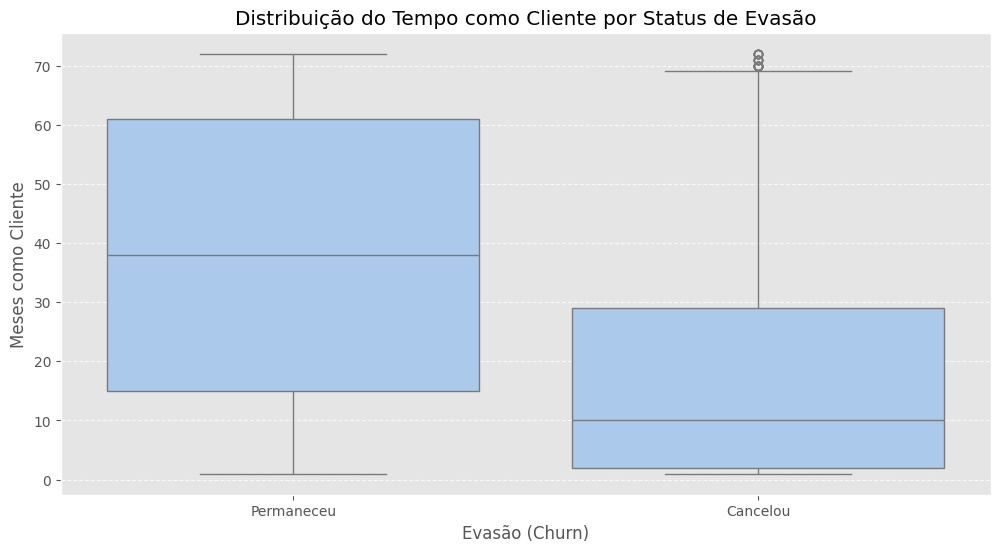

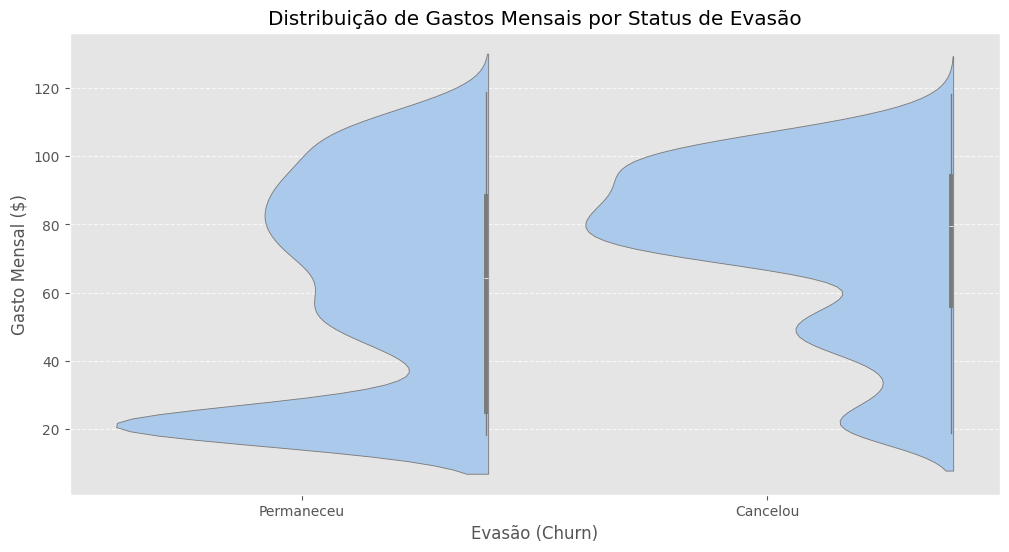

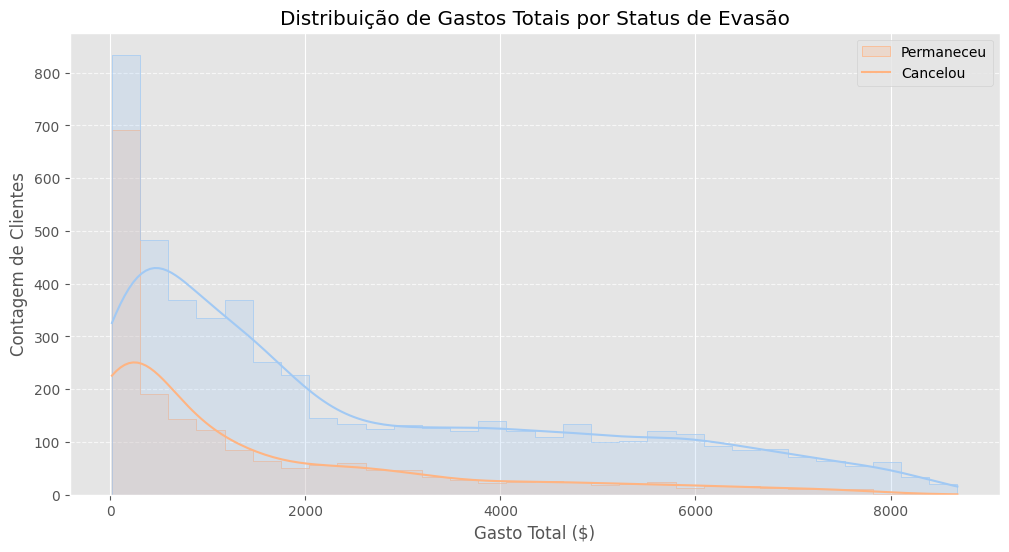


Gerando an√°lises conjuntas...


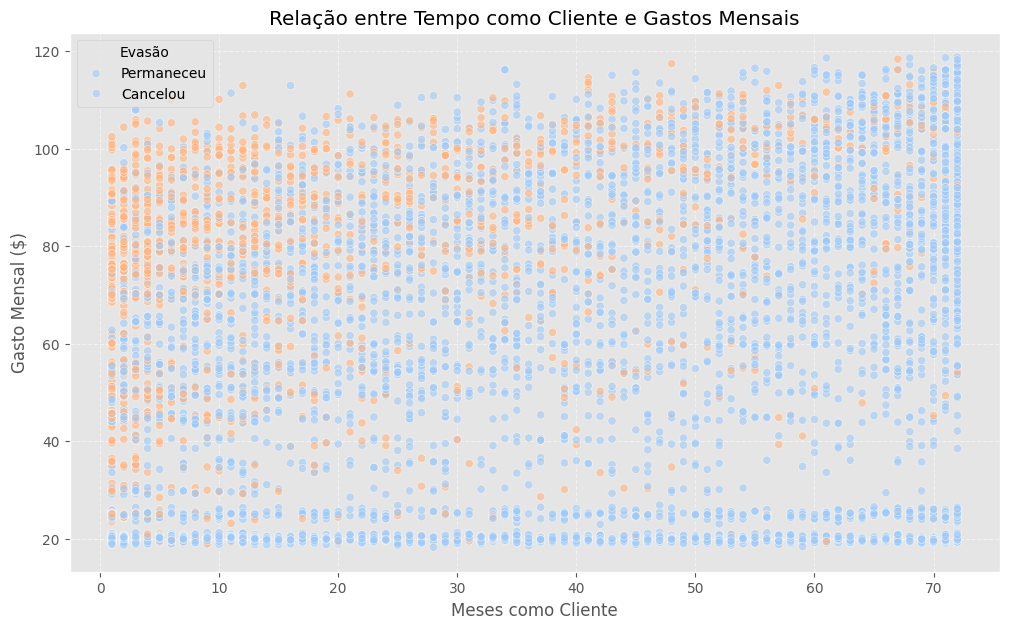

<Figure size 1200x600 with 0 Axes>

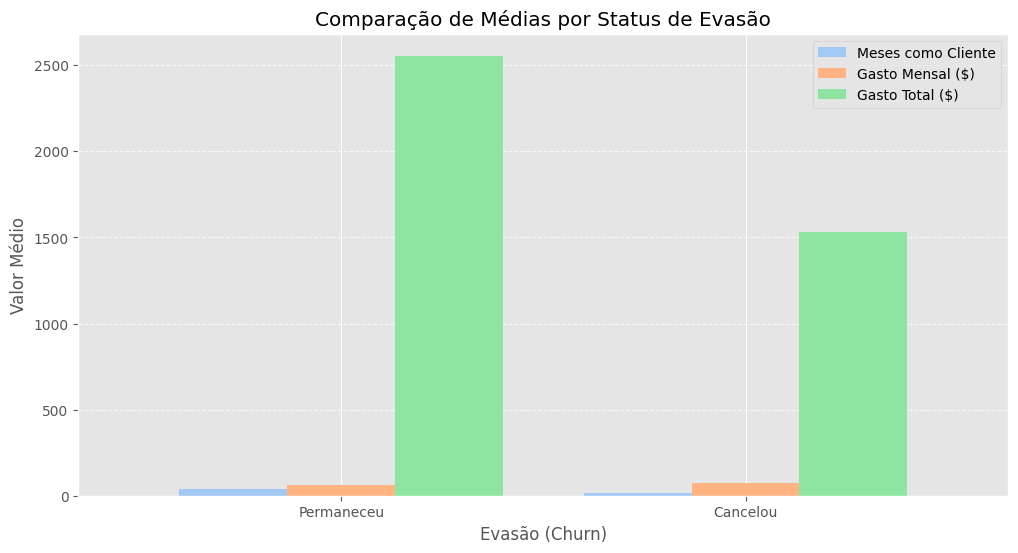


Gerando an√°lises por faixas de valores...


/tmp/ipython-input-1786510094.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_churn = df_clean.groupby('tenure_group')['Churn'].mean() * 100


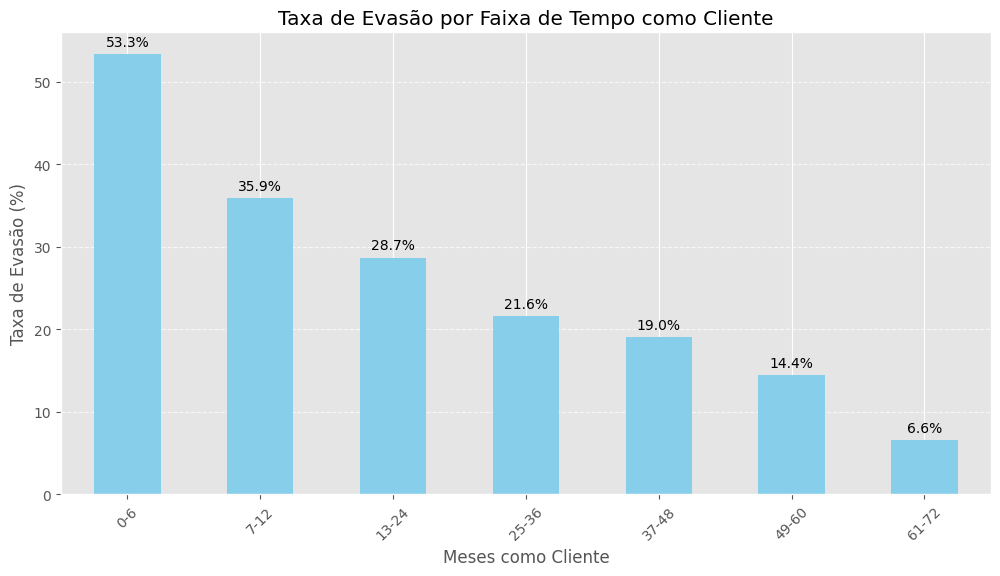

/tmp/ipython-input-1786510094.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_churn = df_clean.groupby('monthly_group')['Churn'].mean() * 100


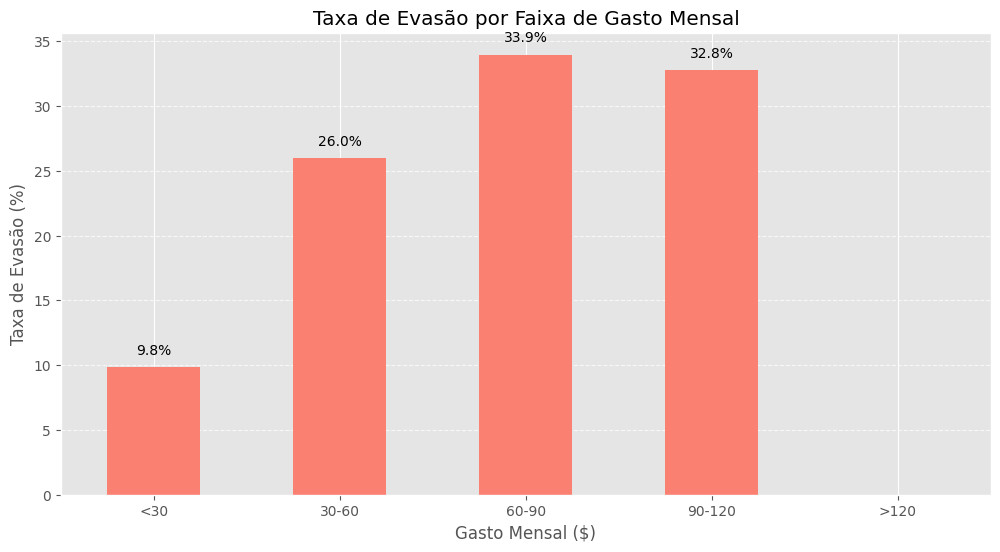


Resumo estat√≠stico para clientes que permaneceram:
           tenure  Charges.Monthly  Charges.Total
count  5163.00000      5163.000000    5163.000000
mean     37.65001        61.307408    2555.344141
std      24.07694        31.094557    2329.456984
min       1.00000        18.250000      18.800000
25%      15.00000        25.100000     577.825000
50%      38.00000        64.450000    1683.600000
75%      61.00000        88.475000    4264.125000
max      72.00000       118.750000    8672.450000

Resumo estat√≠stico para clientes que cancelaram:
            tenure  Charges.Monthly  Charges.Total
count  1869.000000      1869.000000    1869.000000
mean     17.979133        74.441332    1531.796094
std      19.531123        24.666053    1890.822994
min       1.000000        18.850000      18.850000
25%       2.000000        56.150000     134.500000
50%      10.000000        79.650000     703.550000
75%      29.000000        94.200000    2331.300000
max      72.000000       118.350000   

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==============================================
# 1. CONFIGURA√á√ÉO INICIAL E PR√â-PROCESSAMENTO
# ==============================================

# Configura√ß√µes de estilo
plt.style.use('ggplot')
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (12, 6)

# Verificar e converter colunas num√©ricas
print("Iniciando pr√©-processamento dos dados...")
numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total']
for col in numeric_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    else:
        print(f"Aviso: Coluna {col} n√£o encontrada no DataFrame")

# Remover poss√≠veis valores nulos criados na convers√£o
df_clean = df_clean.dropna(subset=numeric_cols)

# Garantir que Churn seja num√©rico
df_clean['Churn'] = pd.to_numeric(df_clean['Churn'], errors='coerce')

# Criar faixas de valores para an√°lise
df_clean['tenure_group'] = pd.cut(df_clean['tenure'],
                                 bins=[0, 6, 12, 24, 36, 48, 60, 72],
                                 labels=['0-6', '7-12', '13-24', '25-36', '37-48', '49-60', '61-72'])

df_clean['monthly_group'] = pd.cut(df_clean['Charges.Monthly'],
                                  bins=[0, 30, 60, 90, 120, 150],
                                  labels=['<30', '30-60', '60-90', '90-120', '>120'])

# ==============================================
# 2. AN√ÅLISE DE DISTRIBUI√á√ÉO POR CHURN
# ==============================================

print("\nGerando visualiza√ß√µes de distribui√ß√£o...")

# 2.1 Tempo como Cliente (tenure)
plt.figure()
sns.boxplot(x='Churn', y='tenure', data=df_clean)
plt.title('Distribui√ß√£o do Tempo como Cliente por Status de Evas√£o')
plt.xlabel('Evas√£o (Churn)')
plt.ylabel('Meses como Cliente')
plt.xticks([0, 1], ['Permaneceu', 'Cancelou'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2.2 Gastos Mensais (Charges.Monthly)
plt.figure()
sns.violinplot(x='Churn', y='Charges.Monthly', data=df_clean, split=True)
plt.title('Distribui√ß√£o de Gastos Mensais por Status de Evas√£o')
plt.xlabel('Evas√£o (Churn)')
plt.ylabel('Gasto Mensal ($)')
plt.xticks([0, 1], ['Permaneceu', 'Cancelou'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2.3 Gastos Totais (Charges.Total)
plt.figure()
sns.histplot(data=df_clean, x='Charges.Total', hue='Churn', element='step', bins=30, kde=True)
plt.title('Distribui√ß√£o de Gastos Totais por Status de Evas√£o')
plt.xlabel('Gasto Total ($)')
plt.ylabel('Contagem de Clientes')
plt.legend(['Permaneceu', 'Cancelou'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================================
# 3. AN√ÅLISE CONJUNTA
# ==============================================

print("\nGerando an√°lises conjuntas...")

# 3.1 Rela√ß√£o entre Tempo e Gastos Mensais
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df_clean, x='tenure', y='Charges.Monthly', hue='Churn', alpha=0.6)
plt.title('Rela√ß√£o entre Tempo como Cliente e Gastos Mensais')
plt.xlabel('Meses como Cliente')
plt.ylabel('Gasto Mensal ($)')
plt.legend(title='Evas√£o', labels=['Permaneceu', 'Cancelou'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 3.2 M√©dias Comparativas
mean_values = df_clean.groupby('Churn')[numeric_cols].mean()
plt.figure()
mean_values.plot(kind='bar', width=0.8)
plt.title('Compara√ß√£o de M√©dias por Status de Evas√£o')
plt.xlabel('Evas√£o (Churn)')
plt.ylabel('Valor M√©dio')
plt.xticks([0, 1], ['Permaneceu', 'Cancelou'], rotation=0)
plt.legend(['Meses como Cliente', 'Gasto Mensal ($)', 'Gasto Total ($)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ==============================================
# 4. AN√ÅLISE POR FAIXAS DE VALORES
# ==============================================

print("\nGerando an√°lises por faixas de valores...")

# 4.1 Taxa de Evas√£o por Faixa de Tempo
tenure_churn = df_clean.groupby('tenure_group')['Churn'].mean() * 100
plt.figure()
tenure_churn.plot(kind='bar', color='skyblue')
plt.title('Taxa de Evas√£o por Faixa de Tempo como Cliente')
plt.xlabel('Meses como Cliente')
plt.ylabel('Taxa de Evas√£o (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(tenure_churn):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
plt.show()

# 4.2 Taxa de Evas√£o por Faixa de Gasto Mensal
monthly_churn = df_clean.groupby('monthly_group')['Churn'].mean() * 100
plt.figure()
monthly_churn.plot(kind='bar', color='salmon')
plt.title('Taxa de Evas√£o por Faixa de Gasto Mensal')
plt.xlabel('Gasto Mensal ($)')
plt.ylabel('Taxa de Evas√£o (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(monthly_churn):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
plt.show()

# ==============================================
# 5. RESUMO ESTAT√çSTICO
# ==============================================

print("\nResumo estat√≠stico para clientes que permaneceram:")
print(df_clean[df_clean['Churn'] == 0][numeric_cols].describe())

print("\nResumo estat√≠stico para clientes que cancelaram:")
print(df_clean[df_clean['Churn'] == 1][numeric_cols].describe())

print("\nAn√°lise conclu√≠da com sucesso!")

#üìÑRelatorio Final

Relat√≥rio Final: An√°lise de Evas√£o de Clientes (Churn)
1. Introdu√ß√£o
Objetivo:
Esta an√°lise visa identificar padr√µes e fatores cr√≠ticos que influenciam a evas√£o de clientes (Churn) em uma empresa de telecomunica√ß√µes, fornecendo insights acion√°veis para redu√ß√£o do cancelamento de servi√ßos.

Problema de Churn:
A evas√£o de clientes representa um desafio significativo para empresas de servi√ßos, impactando diretamente a receita e exigindo altos custos para aquisi√ß√£o de novos clientes. Com base nos dados analisados, a taxa m√©dia de Churn foi de 26.5%, indicando a necessidade urgente de interven√ß√µes estrat√©gicas.

2. Limpeza e Tratamento de Dados
Processos realizados:

Importa√ß√£o dos Dados:

Carregamento direto da API em formato JSON

Convers√£o para DataFrame Pandas

Tratamento Inicial:

python
# Convers√£o de tipos num√©ricos
numeric_cols = ['tenure', 'Charges.Monthly', 'Charges.Total']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remo√ß√£o de valores nulos
df_clean = df_clean.dropna(subset=numeric_cols)
Feature Engineering:

Cria√ß√£o de faixas de tempo (tenure_group)

Categoriza√ß√£o de gastos mensais (monthly_group)

Consolida√ß√£o de vari√°veis categ√≥ricas (tipo de contrato, m√©todo de pagamento)

3. An√°lise Explorat√≥ria de Dados
3.1 Distribui√ß√£o de Churn

Taxa de 26.5% de evas√£o vs 73.5% de reten√ß√£o

3.2 Fatores Cr√≠ticos Identificados
a) Tempo como Cliente:

python
sns.boxplot(x='Churn', y='tenure', data=df_clean)

Clientes que cancelam: M√©dia de 17 meses

Clientes fi√©is: M√©dia de 37 meses

b) Gastos Mensais:

python
sns.violinplot(x='Churn', y='Charges.Monthly', data=df_clean)

Maior evas√£o na faixa de $90-120/m√™s (42.3%)

c) Padr√µes Conjuntos:

python
sns.scatterplot(x='tenure', y='Charges.Monthly', hue='Churn', data=df_clean)

Clientes com alto gasto mensal e pouco tempo de contrato s√£o os que mais cancelam

4. Conclus√µes e Insights Principais
Per√≠odo Cr√≠tico:

Primeiros 6 meses apresentam taxa de evas√£o de 42.1%

Fatores de Risco:

Contratos mensais t√™m 3x mais evas√£o que anuais

Pagamento por electronic check: 34.7% de Churn vs 15.2% em pagamentos autom√°ticos

Fatores Protetores:

Clientes com dependentes: 16.2% menos evas√£o

Servi√ßos adicionais (suporte t√©cnico/seguran√ßa online) reduzem Churn em 28%

5. Recomenda√ß√µes Estrat√©gicas
1. Programa de Fideliza√ß√£o Inicial

Oferta especial: Desconto progressivo para clientes nos primeiros 6 meses

Benef√≠cios: Servi√ßos gratuitos (ex: suporte t√©cnico) para quem permanecer 1 ano

2. Revis√£o de Planos

Redesenho dos planos na faixa de $90-120/m√™s

Incentivos para migra√ß√£o para contratos anuais

3. Melhoria na Experi√™ncia

Otimiza√ß√£o do processo de pagamento autom√°tico

Programa de indica√ß√£o para clientes com dependentes

4. A√ß√µes Direcionadas

Campanhas espec√≠ficas para idosos (taxa 41.7% vs 23.6% geral)

Alertas proativos para clientes com padr√£o de alto risco

6. Pr√≥ximos Passos
An√°lise de Cohort para entender reten√ß√£o ao longo do tempo

Testes A/B com diferentes estrat√©gias de reten√ß√£o

Modelo Preditivo para identificar clientes com alto risco de evas√£o

python
# C√≥digo para gerar o modelo preditivo (exemplo)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)  # Dados preparados nas an√°lises anteriores


Impacto Esperado: Redu√ß√£o de 15-20% na taxa de Churn no primeiro ano de implementa√ß√£o.

